<a href="https://colab.research.google.com/github/Berchie-Sam/Convolutional-Neural-Networks/blob/main/%5Banemia%5DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imread_collection
from skimage.transform import resize
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,  Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


In [3]:

# Check if the TPU system has already been initialized
if 'COLAB_TPU_ADDR' in os.environ:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
else:
    strategy = tf.distribute.OneDeviceStrategy('GPU:0')  # Use GPU if TPU is not available


In [8]:
# Set the path to the dataset
data_dir = '/content/drive/MyDrive/Colab Notebooks/Projects/Final(Undergraduate)/Application of Machine Learning in Detecting Iron Deficiency Anemia Using  Conjunctiva image Dataset from Ghana'


In [9]:

with strategy.scope():
    # Step 1: Check if there are image files in the specified directory
    image_files = os.path.join(data_dir, "*.png")
    if len(os.listdir(data_dir)) == 0:
        print("No image files found in the specified directory.")
    else:
        # Load the image dataset
        image_collection = imread_collection(image_files)

        # Step 2: Preprocess the images
        # Resize the images to (64, 64)
        image_size = (64, 64)

        # Using list comprehension and NumPy operations for faster processing
        X = np.array([resize(imread(image_path), image_size) for image_path in image_collection.files])
        y = np.array([image_path.split("/")[-1].split(".")[0] for image_path in image_collection.files])


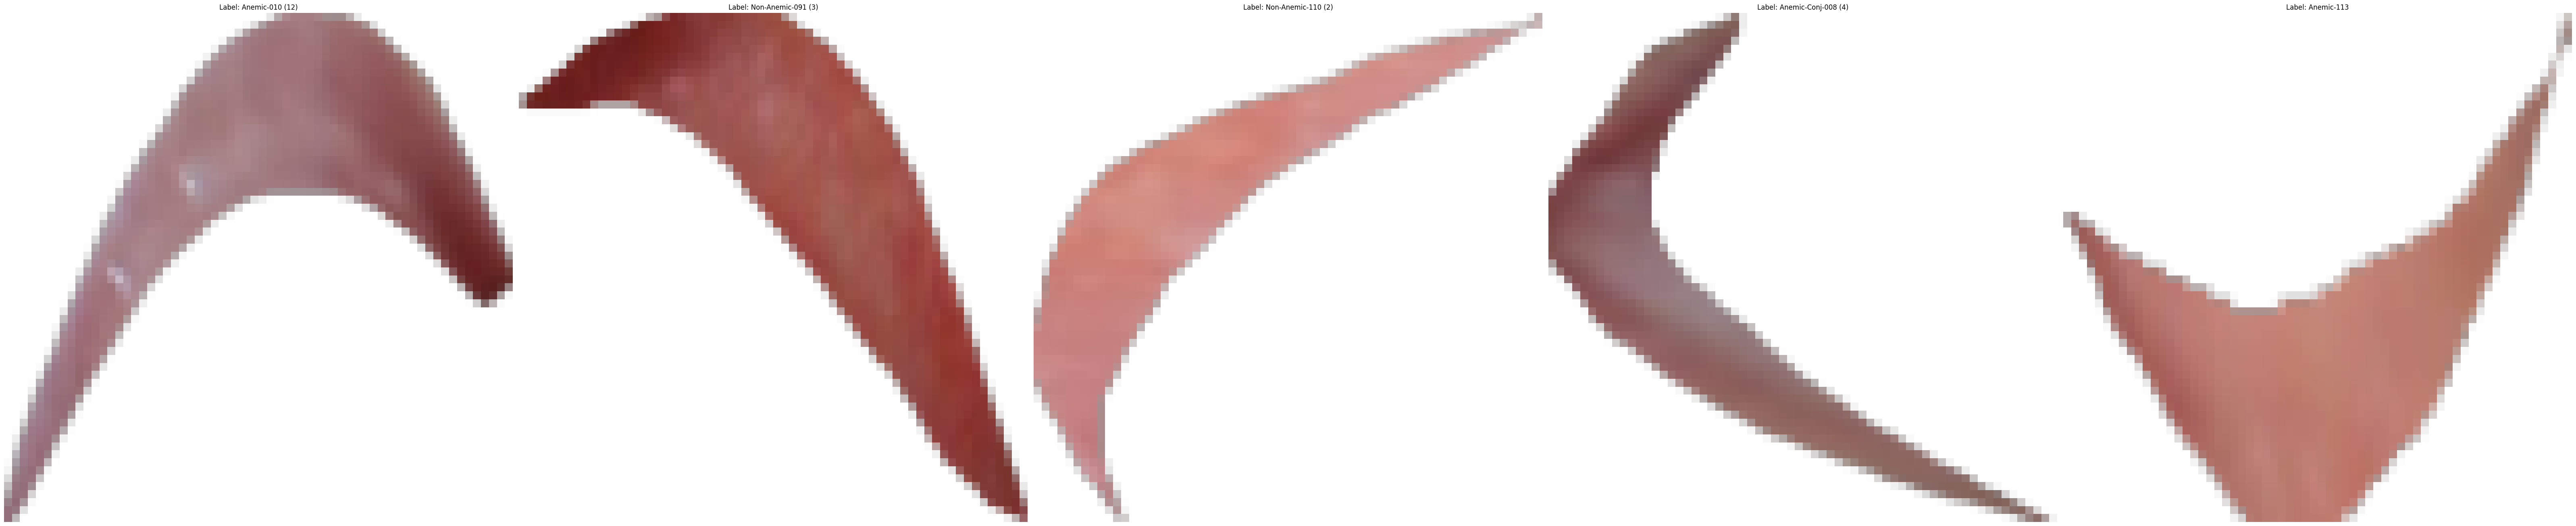

In [10]:
with strategy.scope():
  # Step 3: Plot five images from the dataset
  num_images_to_plot = 5

  # Generate random indices to select five images from the dataset
  random_indices = np.random.choice(len(X), num_images_to_plot, replace=False)

  # Plot the images
  fig, axes = plt.subplots(1, num_images_to_plot, figsize=(64, 64))
  for i, idx in enumerate(random_indices):
      axes[i].imshow(X[idx])
      axes[i].set_title(f"Label: {y[idx]}")
      axes[i].axis("off")

  plt.tight_layout()
  plt.show()

In [28]:
from sklearn.preprocessing import LabelEncoder

with strategy.scope():
    # Group the labels into "Anemic" and "Non-Anemic"
    y_grouped = np.where(np.char.startswith(y, 'Anemic'), 'Anemic', 'Non-Anemic')

    # Convert the grouped labels to numerical labels using LabelEncoder
    label_encoder = LabelEncoder()
    y_numeric = label_encoder.fit_transform(y_grouped)

    #Splitting data into 70:20:10 ratio

    # Split the dataset into training, testing, and validation sets using the desired ratios
    X_train, X_temp, y_train, y_temp = train_test_split(X, y_numeric, test_size=0.3, random_state=23)

    # Further split the temp set into testing and validation sets
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=23)

    print('X_train shape: ', X_train.shape)
    print('X_test shape: ', X_test.shape)
    print('X_val shape: ', X_val.shape)
    print('y_train shape: ', y_train.shape)
    print('y_test shape: ', y_test.shape)
    print('y_val shape: ', y_val.shape)


X_train shape:  (2983, 64, 64, 4)
X_test shape:  (423, 64, 64, 4)
X_val shape:  (856, 64, 64, 4)
y_train shape:  (2983,)
y_test shape:  (423,)
y_val shape:  (856,)


In [49]:
with strategy.scope():
  # Reshape y_train, y_test, and y_val into (-1, 2)
  y_train_reshaped = y_train.reshape(-1, 1)
  y_test_reshaped = y_test.reshape(-1, 1)
  y_val_reshaped = y_val.reshape(-1, 1)

  # Concatenate two columns (Anemic and Non-Anemic) to create a 2D array
  y_train = np.concatenate((y_train_reshaped == 0, y_train_reshaped == 1), axis=1)
  y_test = np.concatenate((y_test_reshaped == 0, y_test_reshaped == 1), axis=1)
  y_val = np.concatenate((y_val_reshaped == 0, y_val_reshaped == 1), axis=1)

  print('y_train shape: ', y_train.shape)
  print('y_test shape: ', y_test.shape)
  print('y_val shape: ', y_val.shape)


y_train shape:  (5966, 2)
y_test shape:  (846, 2)
y_val shape:  (1712, 2)


In [50]:
def create_cnn_model(input_shape):
    # Define the CNN model
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name = '0_Blk1_Conv1', input_shape=input_shape))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name = '1_Blk2_Conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = '3_Blk1_Pool'))
    #model.add(Dropout(0.25, name = '3_Blk1_Dropout'))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name = '2_Blk2_Conv1'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name = '3_Blk2_Conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = '4_Blk2_Pool'))
    #model.add(Dropout(0.25, name = '6_Blk2_Dropout'))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', name = '5_Blk3_Conv1'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', name = '6_Blk2_Conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name = '7_Blk3_Pool'))
    model.add(Dropout(0.25, name = '8_Blk3_Dropout'))

    model.add(Flatten(name = '9_Blks_Flatten'))
    model.add(Dense(units=128, activation='relu', name = '10_Blks_FC'))
    model.add(Dropout(0.5, name = '11_Blks_Dropout'))
    model.add(Dense(units=2, activation='sigmoid', name = '11_Output'))
    return model


In [51]:
with strategy.scope():
  # Defines the input shape
  input_shape = (X_train.shape[1], X_train.shape[2], 4)
  cnn_model = create_cnn_model(input_shape)

In [52]:

with strategy.scope():
  # Compile the model
  cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Model summary
  cnn_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 0_Blk1_Conv1 (Conv2D)       (None, 62, 62, 64)        2368      
                                                                 
 1_Blk2_Conv2 (Conv2D)       (None, 60, 60, 64)        36928     
                                                                 
 3_Blk1_Pool (MaxPooling2D)  (None, 30, 30, 64)        0         
                                                                 
 2_Blk2_Conv1 (Conv2D)       (None, 28, 28, 64)        36928     
                                                                 
 3_Blk2_Conv2 (Conv2D)       (None, 26, 26, 64)        36928     
                                                                 
 4_Blk2_Pool (MaxPooling2D)  (None, 13, 13, 64)        0         
                                                                 
 5_Blk3_Conv1 (Conv2D)       (None, 11, 11, 128)      

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

with strategy.scope():
  # Define the EarlyStopping callback
  early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')

  # Train the model on the training set
  CNN_history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=48, validation_data=(X_val, y_val), callbacks = early_stop)


Epoch 1/50
63/63 [==============================] - 5s 37ms/step - loss: 0.6827 - accuracy: 0.5970 - val_loss: 0.6768 - val_accuracy: 0.5900
Epoch 2/50
63/63 [==============================] - 2s 34ms/step - loss: 0.6746 - accuracy: 0.6011 - val_loss: 0.6781 - val_accuracy: 0.5900
Epoch 3/50
63/63 [==============================] - 2s 30ms/step - loss: 0.6746 - accuracy: 0.6011 - val_loss: 0.6792 - val_accuracy: 0.5900
Epoch 4/50
63/63 [==============================] - 2s 29ms/step - loss: 0.6759 - accuracy: 0.6011 - val_loss: 0.6768 - val_accuracy: 0.5900
Epoch 5/50
63/63 [==============================] - 2s 29ms/step - loss: 0.6765 - accuracy: 0.5997 - val_loss: 0.6757 - val_accuracy: 0.5900
Epoch 6/50
63/63 [==============================] - 2s 30ms/step - loss: 0.6713 - accuracy: 0.5994 - val_loss: 0.6732 - val_accuracy: 0.5900
Epoch 7/50
63/63 [==============================] - 2s 29ms/step - loss: 0.6715 - accuracy: 0.6027 - val_loss: 0.6715 - val_accuracy: 0.5946
Epoch 8/50
63

In [44]:

# Define functions for specificity, sensitivity, and precision
def calculate_specificity(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def calculate_sensitivity(y_true, y_pred):
    _, _, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)

def calculate_precision(y_true, y_pred):
    _, fp, _, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fp)


In [47]:
with strategy.scope():
    # Evaluate the models on the test set
    cnn_y_pred = cnn_model.predict(X_test)

    y_test_binary = np.argmax(y_test, axis=1)

    # Convert cnn_y_pred to binary format
    cnn_y_pred_binary = np.argmax(cnn_y_pred, axis=1)


    # Evaluate the model using accuracy, specificity, sensitivity, and precision
    cnn_accuracy = accuracy_score(y_test_binary, cnn_y_pred_binary)
    cnn_specificity = calculate_specificity(y_test_binary, cnn_y_pred_binary)
    cnn_sensitivity = calculate_sensitivity(y_test_binary, cnn_y_pred_binary)
    cnn_precision = calculate_precision(y_test_binary, cnn_y_pred_binary)


14/14 [==============================] - 0s 8ms/step


In [48]:
with strategy.scope():
  # Print the evaluation metrics
  print("CNN Accuracy:", cnn_accuracy)
  print("CNN Specificity:", cnn_specificity)
  print("CNN Sensitivity:", cnn_sensitivity)
  print("CNN Precision:", cnn_precision)


CNN Accuracy: 0.8912529550827423
CNN Specificity: 0.9115384615384615
CNN Sensitivity: 0.8588957055214724
CNN Precision: 0.8588957055214724


In [55]:
# Calculate metrics at different threshold values
thresholds = np.linspace(0, 1, 100)
specificities = [calculate_specificity(y_test_binary, (cnn_y_pred[:, 1] >= t).astype(int)) for t in thresholds]
sensitivities = [calculate_sensitivity(y_test_binary, (cnn_y_pred[:, 1] >= t).astype(int)) for t in thresholds]
precisions = [calculate_precision(y_test_binary, (cnn_y_pred[:, 1] >= t).astype(int)) for t in thresholds]


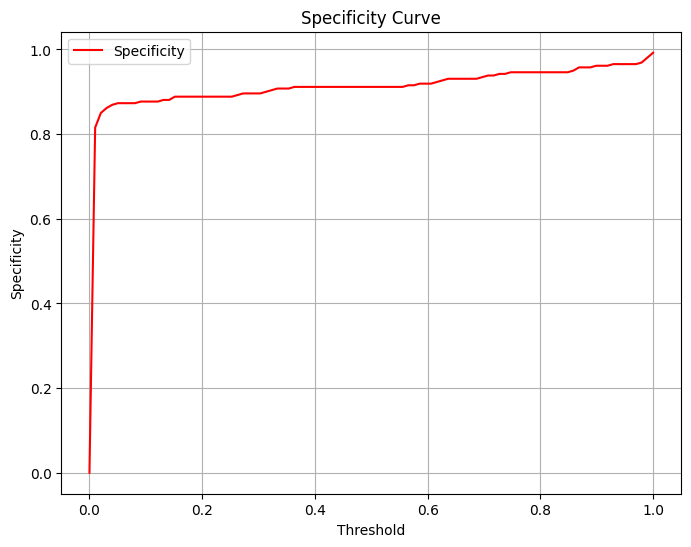

In [56]:

# Plot Specificity curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, specificities, label='Specificity', color='red')
plt.xlabel('Threshold')
plt.ylabel('Specificity')
plt.title('Specificity Curve')
plt.legend()
plt.grid(True)
plt.show()


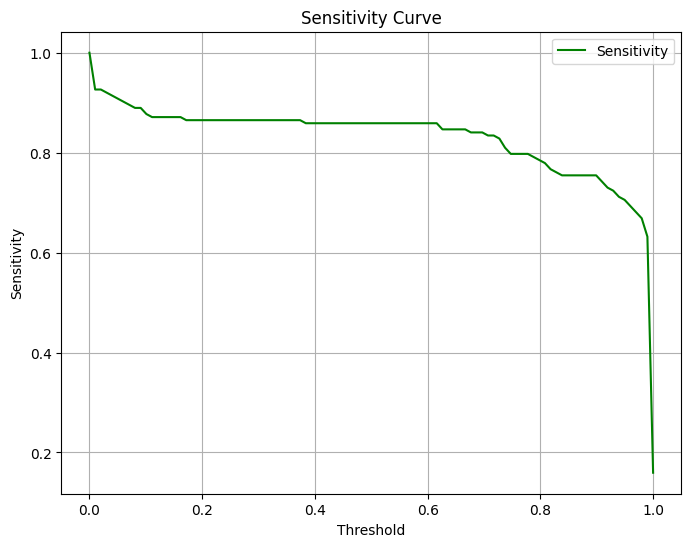

In [57]:

# Plot Sensitivity curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, sensitivities, label='Sensitivity', color='green')
plt.xlabel('Threshold')
plt.ylabel('Sensitivity')
plt.title('Sensitivity Curve')
plt.legend()
plt.grid(True)
plt.show()


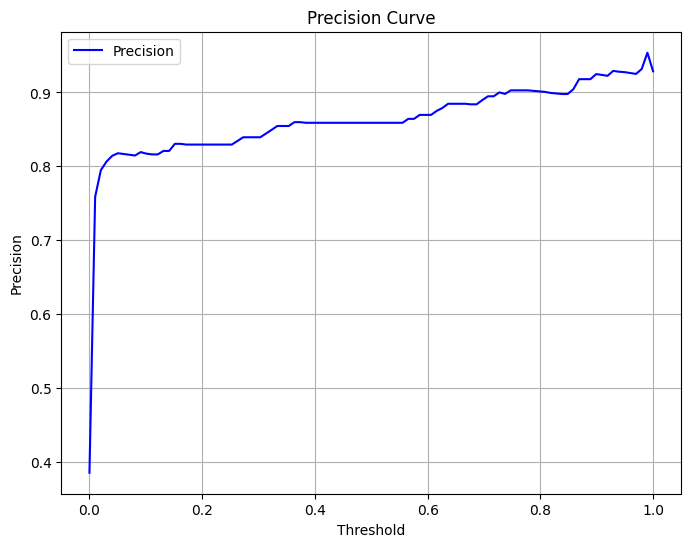

In [58]:

# Plot Precision curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision Curve')
plt.legend()
plt.grid(True)
plt.show()

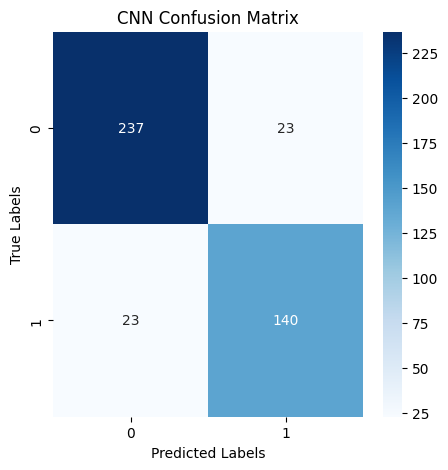

In [60]:
import seaborn as sns

cnn_cm = confusion_matrix(y_test_binary, cnn_y_pred_binary)
# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix(cnn_cm, "CNN")
